<a href="https://colab.research.google.com/github/gigihsantoso/prediksi-berlangganan-deposito-berjangka-deeplearning/blob/main/Deep_Learning_Fintech.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fintech

"Data tersebut terkait dengan kampanye pemasaran langsung dari lembaga perbankan Portugis. Kampanye pemasaran didasarkan pada panggilan telepon. Seringkali, lebih dari satu kontak ke klien yang sama diperlukan, untuk mengakses apakah produk (deposito berjangka bank) akan ('ya') atau tidak ('tidak') dilanggan oleh pelanggan atau tidak. Folder data berisi dua kumpulan data: -

     train.csv: 45.211 baris dan 18 kolom diurutkan berdasarkan tanggal (dari Mei 2008 hingga November 2010)
     test.csv: 4521 baris dan 18 kolom dengan 10% contoh (4521), dipilih secara acak dari train.csv"

### Variabel input:
1.  age : umur (Numeric)
2.  job: jenis pekerjaan (Categorical)
3.  marital : status perkawinan (Categorical)
4.  education : Pendidikan (Categorical)
5.  default: memiliki kredit dalam default? (Categorical) 
6.  perumahan: memiliki pinjaman perumahan? (Categorical)
7.  loan: memiliki pinjaman pribadi? (Categorical)

### Terkait dengan kontak terakhir kampanye saat ini:
8.  contact: jenis komunikasi kontak (Numeric)
9.  month: kontak terakhir bulan tahun (Numeric)
10. day: hari kontak terakhir dalam seminggu (Numeric)
11. duration: durasi kontak terakhir, dalam detik (Numeric)

### Atribut lainnya:
12. campaign: jumlah kontak yang dilakukan selama kampanye ini dan untuk klien ini (Numeric)
13. pdays: jumlah hari yang berlalu setelah klien terakhir dihubungi dari kampanye sebelumnya (numerik; 999 berarti klien tidak sebelumnya dihubungi)
14. previous: jumlah kontak yang dilakukan sebelum kampanye ini dan untuk klien ini (numerik)
15. poutcome: hasil dari kampanye pemasaran sebelumnya (kategori: 'gagal', 'tidak ada', 'sukses')

Sumber: [Dataset Bank Marketing Portugis](http://archive.ics.uci.edu/ml/datasets/Bank+Marketing#)

##Setup

In [1]:
import pathlib
import tensorflow as tf
import zipfile
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from google.colab import drive
from google.colab import data_table
import tensorflow as tf
from sklearn.metrics import confusion_matrix

##Function

function split data

In [2]:
def dataframe_split(data, ratio= 0.2, shuffle= 0):
  len_ = int(len(data) - (ratio*len(data)))
  if shuffle == 0 :
    part_  = data.iloc[:int(1 + len_)]
    rest_part_ = data.drop(part_.index)
  elif shuffle == 1:
    part_ = data.sample(frac = 1.0 - ratio)
    rest_part_ = data.drop(part_.index)
  return (part_, rest_part_)

fucntion membuat dataset

In [3]:
def dataframe_to_dataset(data, batch_size=32):
  df = data.copy()
  labels = df.pop('target')
  df = {key:  tf.expand_dims(value,axis=1) for key, value in df.items()}
  ds = tf.data.Dataset.from_tensor_slices((df, labels))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

In [4]:
def dataframe_imbalance_to_dataset(data, batch_size=32):
  df = data.copy()
  labels = df.pop('target')
  df = {key:  tf.expand_dims(value,axis=1) for key, value in df.items()}
  data = tf.data.Dataset.from_tensor_slices((dict(df), labels)).batch(batch_size)

  no_ds = (data
          .unbatch()
          .filter(lambda features, label: label==0)
          .repeat())
  yes_ds = (data
            .unbatch()
            .filter(lambda features, label: label==1)
            .repeat())
  
  ds = tf.data.Dataset.sample_from_datasets([no_ds, yes_ds], weights=[0.5, 0.5])
  ds = ds.batch(batch_size)
  ds = ds.prefetch(tf.data.AUTOTUNE)
  return ds

function preprocessing numeric

In [5]:
def numeric_preprocessing(name, dataset, step):
  feature_dataset = dataset.map(lambda x,y: x[name])
  # layer = tf.keras.layers.Discretization(num_bins=num_bins, epsilon=0.01)
  layer = tf.keras.layers.Normalization()
  layer.adapt(feature_dataset, steps=step)

  return layer

In [6]:
def numeric_to_categories_preprocessing(name, dataset, step, num_bins, num_tokens):
  feature_dataset = dataset.map(lambda x,y: x[name])
  layer = tf.keras.layers.Discretization(num_bins=num_bins, epsilon=0.00001)
  layer.adapt(feature_dataset, steps=step)

  # return lookup
  category_encoding = tf.keras.layers.CategoryEncoding(num_tokens=num_tokens)
  return lambda feature:  category_encoding(layer(feature))

fucntion preprocessing categories

In [7]:
def categories_preprocessing(name, dataset, dtype, step):
  if(dtype == "int64"):
    lookup = tf.keras.layers.IntegerLookup()
  else:
    lookup = tf.keras.layers.StringLookup()
  feature_dataset = dataset.map(lambda x,y: x[name])
  lookup.adapt(feature_dataset, steps=step)

  # return lookup
  category_encoding = tf.keras.layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())
  return lambda feature:  category_encoding(lookup(feature))

plot metric

In [8]:
def plot_metric(x, y, history, metric):
  fig, ax = plt.subplots(x, y, figsize=(15,10))
  epochs = range(len(history.history[metric[0]]))
  for metric, ax in zip(metric, ax.flatten()):
    ax.plot(epochs, history.history[metric], 'r', label='train')
    ax.plot(epochs, history.history['val_'+metric], 'b', ls="--", label='val')
    ax.set_ylabel(metric)
    ax.set_xlabel('epoch')
    ax.legend()  
  plt.show()

plot confution matrix

In [9]:
def plot_confution_matrix(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

## Mount Google Drive

In [10]:
drive.mount('/content/drive')

Mounted at /content/drive


## Load Data

In [50]:
data_url = "/content/drive/MyDrive/Datasets/fintech_banking_dataset.zip"
data_dir = zipfile.ZipFile(data_url, 'r')
data_dir.extractall("MyFile")
data_dir.close()

In [51]:
dataset_train=pd.read_csv('MyFile/train.csv', delimiter=";")
dataset_test=pd.read_csv('MyFile/test.csv', delimiter=";")

##Data Explorer

In [52]:
print(f"jumlah data untuk train adalah {len(dataset_train)}")
print(f"jumlah data untuk test adalah {len(dataset_test)}")

jumlah data untuk train adalah 45211
jumlah data untuk test adalah 4521


In [53]:
dataset_train.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [54]:
dataset_test.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


melihat type pada data set

In [55]:
dataset_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


In [56]:
dataset_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        4521 non-null   int64 
 1   job        4521 non-null   object
 2   marital    4521 non-null   object
 3   education  4521 non-null   object
 4   default    4521 non-null   object
 5   balance    4521 non-null   int64 
 6   housing    4521 non-null   object
 7   loan       4521 non-null   object
 8   contact    4521 non-null   object
 9   day        4521 non-null   int64 
 10  month      4521 non-null   object
 11  duration   4521 non-null   int64 
 12  campaign   4521 non-null   int64 
 13  pdays      4521 non-null   int64 
 14  previous   4521 non-null   int64 
 15  poutcome   4521 non-null   object
 16  y          4521 non-null   object
dtypes: int64(7), object(10)
memory usage: 600.6+ KB


In [57]:
dataset_train_analyst = dataset_train.copy()

In [58]:
numeric_data = dataset_train_analyst.describe()
numeric_data

,age,balance,day,duration,campaign,pdays,previous
count,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000,45211.000000
mean,40.936210,1362.272058,15.806419,258.163080,2.763841,40.197828,0.580323
std,10.618762,3044.765829,8.322476,257.527812,3.098021,100.128746,2.303441
min,18.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,33.000000,72.000000,8.000000,103.000000,1.000000,-1.000000,0.000000
50%,39.000000,448.000000,16.000000,180.000000,2.000000,-1.000000,0.000000
75%,48.000000,1428.000000,21.000000,319.000000,3.000000,-1.000000,0.000000
max,95.000000,102127.000000,31.000000,4918.000000,63.000000,871.000000,275.000000


In [59]:
category_data = dataset_train_analyst.drop(columns=["y"]).describe(include=[object])
category_data

,job,marital,education,default,housing,loan,contact,month,poutcome
count,45211,45211,45211,45211,45211,45211,45211,45211,45211
unique,12,3,4,2,2,2,3,12,4
top,blue-collar,married,secondary,no,yes,no,cellular,may,unknown
freq,9732,27214,23202,44396,25130,37967,29285,13766,36959


###Visualisasi data jumlah variable categorial  

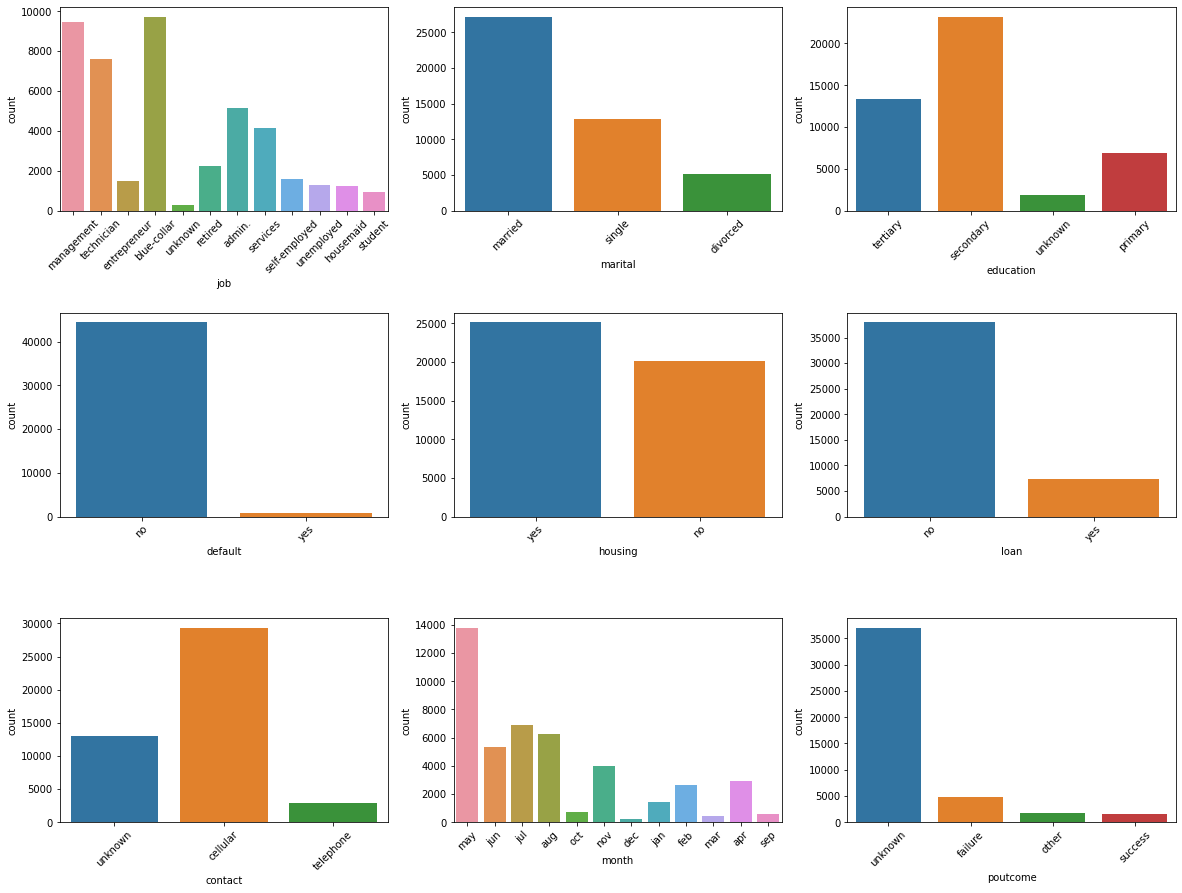

In [60]:
fig, ax = plt.subplots(3, 3, figsize=(20,15))
for col,i in zip(category_data.columns, ax.flatten()):
  g = sns.countplot(x=col, data=dataset_train, ax=i)
  g.tick_params(axis="x", rotation=45)
plt.subplots_adjust(hspace=0.5)
plt.show()

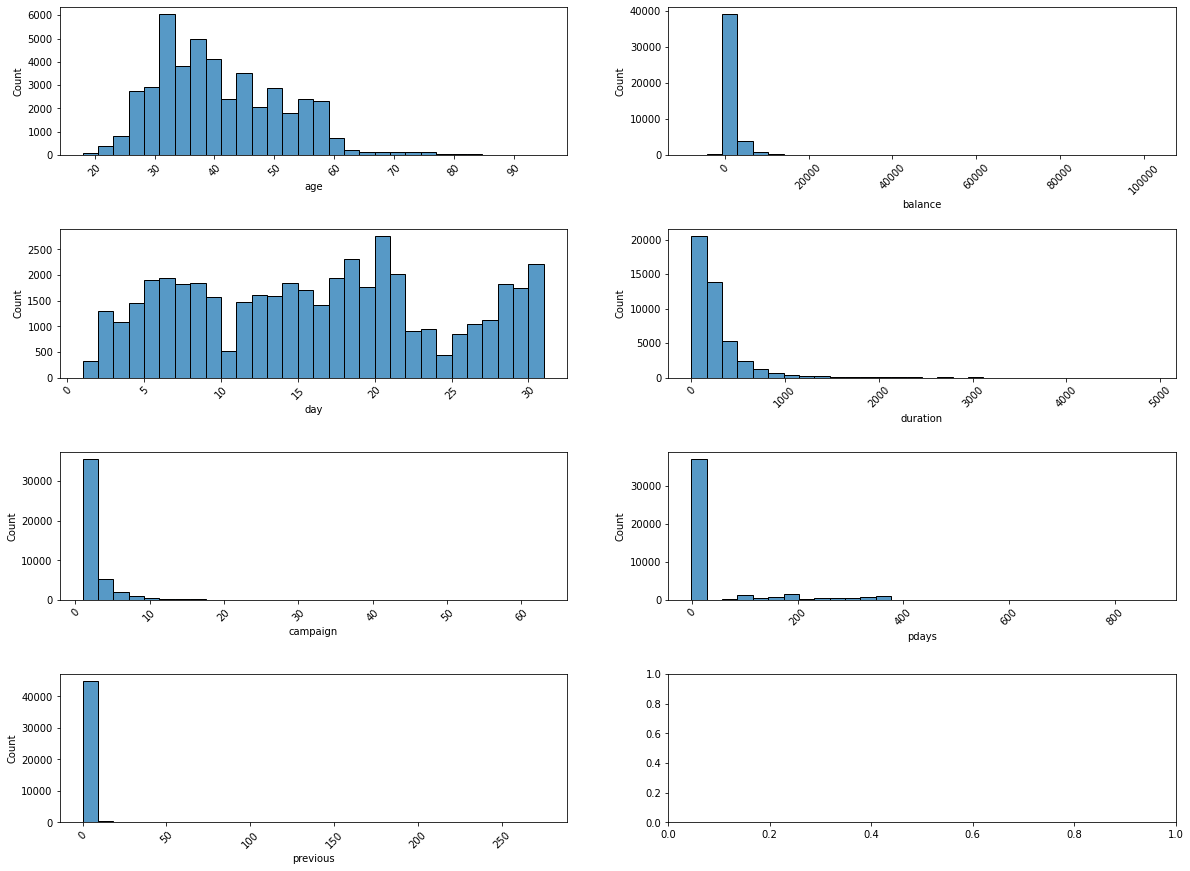

In [61]:
fig, ax = plt.subplots(4, 2, figsize=(20,15))
for col,i in zip(numeric_data.columns, ax.flatten()):
  g = sns.histplot(x=col, data=dataset_train, ax=i, bins=30)
  g.tick_params(axis="x", rotation=45)
plt.subplots_adjust(hspace=0.5)
plt.show()

##Data Preprocessing

mengubah column y, dengan nilai 0 menunjukan *NO* dan nilai 1 menunjukan *YES*

In [62]:
dataset_train['target'] = dataset_train.loc[:, 'y'].apply(lambda x : 0 if x == "no" else 1)

dataset_train.drop(columns=["duration", "contact",	"day", "campaign",	"pdays",	"previous", "poutcome", "y"], inplace=True)

In [63]:
dataset_test['target'] = dataset_test.loc[:, 'y'].apply(lambda x : 0 if x == "no" else 1)

dataset_test.drop(columns=["duration", "contact",	"day", "campaign",	"pdays",	"previous", "poutcome", "y"], inplace=True)

dataset train ini merupakan dataframe pandas, split data train dengan ratio 80:20 . 20 % untuk validasi

In [64]:
train, val = dataframe_split(dataset_train, ratio = 0.3, shuffle=1)

In [65]:
print(len(train), 'training examples')
print(len(val), 'validation examples')

31648 training examples
13563 validation examples


membuat dataset

In [66]:
batch_size = 128
step = 128

train_ds = dataframe_imbalance_to_dataset(train, batch_size=batch_size)
val_ds = dataframe_imbalance_to_dataset(val, batch_size=batch_size)
test_ds = dataframe_to_dataset(dataset_test, batch_size=batch_size)

cek data

In [67]:
for features, labels in train_ds.take(1):
  print(labels.numpy())

[1 0 1 0 1 0 0 1 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 1 1 0 1 0 0 1
 0 0 1 1 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 1 1 1 0
 1 0 0 0 0 1 1 1 0 1 1 1 0 0 1 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 1 0 1 0
 0 0 0 1 1 1 0 1 0 1 0 0 1 0 1 1 1]


membagikan column berdasarkan numeric atau categorical integer atau string

In [68]:
# numeric_keys = ["balance"]
num_to_categorical_keys = ["balance", "age"]
# categorical_integer_keys = ["age"]
categorical_string_keys = ["default", "job", "marital", "education", "housing", "loan", "month"]
all_inputs = []
all_preprocessors = []

In [69]:
# for numeric in numeric_keys:
#   input = tf.keras.Input(shape=(1,), name=numeric, dtype="int64")
#   num_layer = numeric_preprocessing(name=numeric, dataset=train_ds, step=step)
#   num_preprocessor = num_layer(input)
#   all_inputs.append(input)
#   all_preprocessors.append(num_preprocessor)

In [70]:
for categorical in categorical_string_keys:
  input = tf.keras.Input(shape=(1,), name=categorical, dtype="string")
  cat_layer = categories_preprocessing(name=categorical, dataset=train_ds, dtype="string", step=step)
  cat_preprocessor = cat_layer(input)
  all_inputs.append(input)
  all_preprocessors.append(cat_preprocessor)

In [71]:
# for categorical_int in categorical_integer_keys:
#   input = tf.keras.Input(shape=(1,), name=categorical_int, dtype="int64")
#   cat_int_layer = categories_preprocessing(name=categorical_int, dataset=train_ds, dtype="int64", step=step)
#   cat_int_preprocessor = cat_int_layer(input)
#   all_inputs.append(input)
#   all_preprocessors.append(cat_int_preprocessor)

In [72]:
for num_cat in num_to_categorical_keys:
  input = tf.keras.Input(shape=(1,), name=num_cat, dtype="int64")
  num_cat_layer = numeric_to_categories_preprocessing(name=num_cat, dataset=train_ds, step=step, num_bins=30, num_tokens=30)
  num_cat_preprocessor = num_cat_layer(input)
  all_inputs.append(input)
  all_preprocessors.append(num_cat_preprocessor)

In [73]:
all_inputs, all_preprocessors

([<KerasTensor: shape=(None, 1) dtype=string (created by layer 'default')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'job')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'marital')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'education')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'housing')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'loan')>,
  <KerasTensor: shape=(None, 1) dtype=string (created by layer 'month')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'balance')>,
  <KerasTensor: shape=(None, 1) dtype=int64 (created by layer 'age')>],
 [<KerasTensor: shape=(None, 3) dtype=float32 (created by layer 'category_encoding_9')>,
  <KerasTensor: shape=(None, 13) dtype=float32 (created by layer 'category_encoding_10')>,
  <KerasTensor: shape=(None, 4) dtype=float32 (created by layer 'category_encoding_11')>,
  <KerasTensor: shape=(None, 5) dtype=float32 (created by 

##Model

In [74]:
all_features = tf.keras.layers.concatenate(all_preprocessors)
x = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.00000001))(all_features)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.00000001))(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(32, activation=tf.keras.activations.relu, kernel_regularizer=tf.keras.regularizers.L2(0.00000001))(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(1, activation=tf.keras.activations.sigmoid)(x)

model = tf.keras.Model(all_inputs, output)

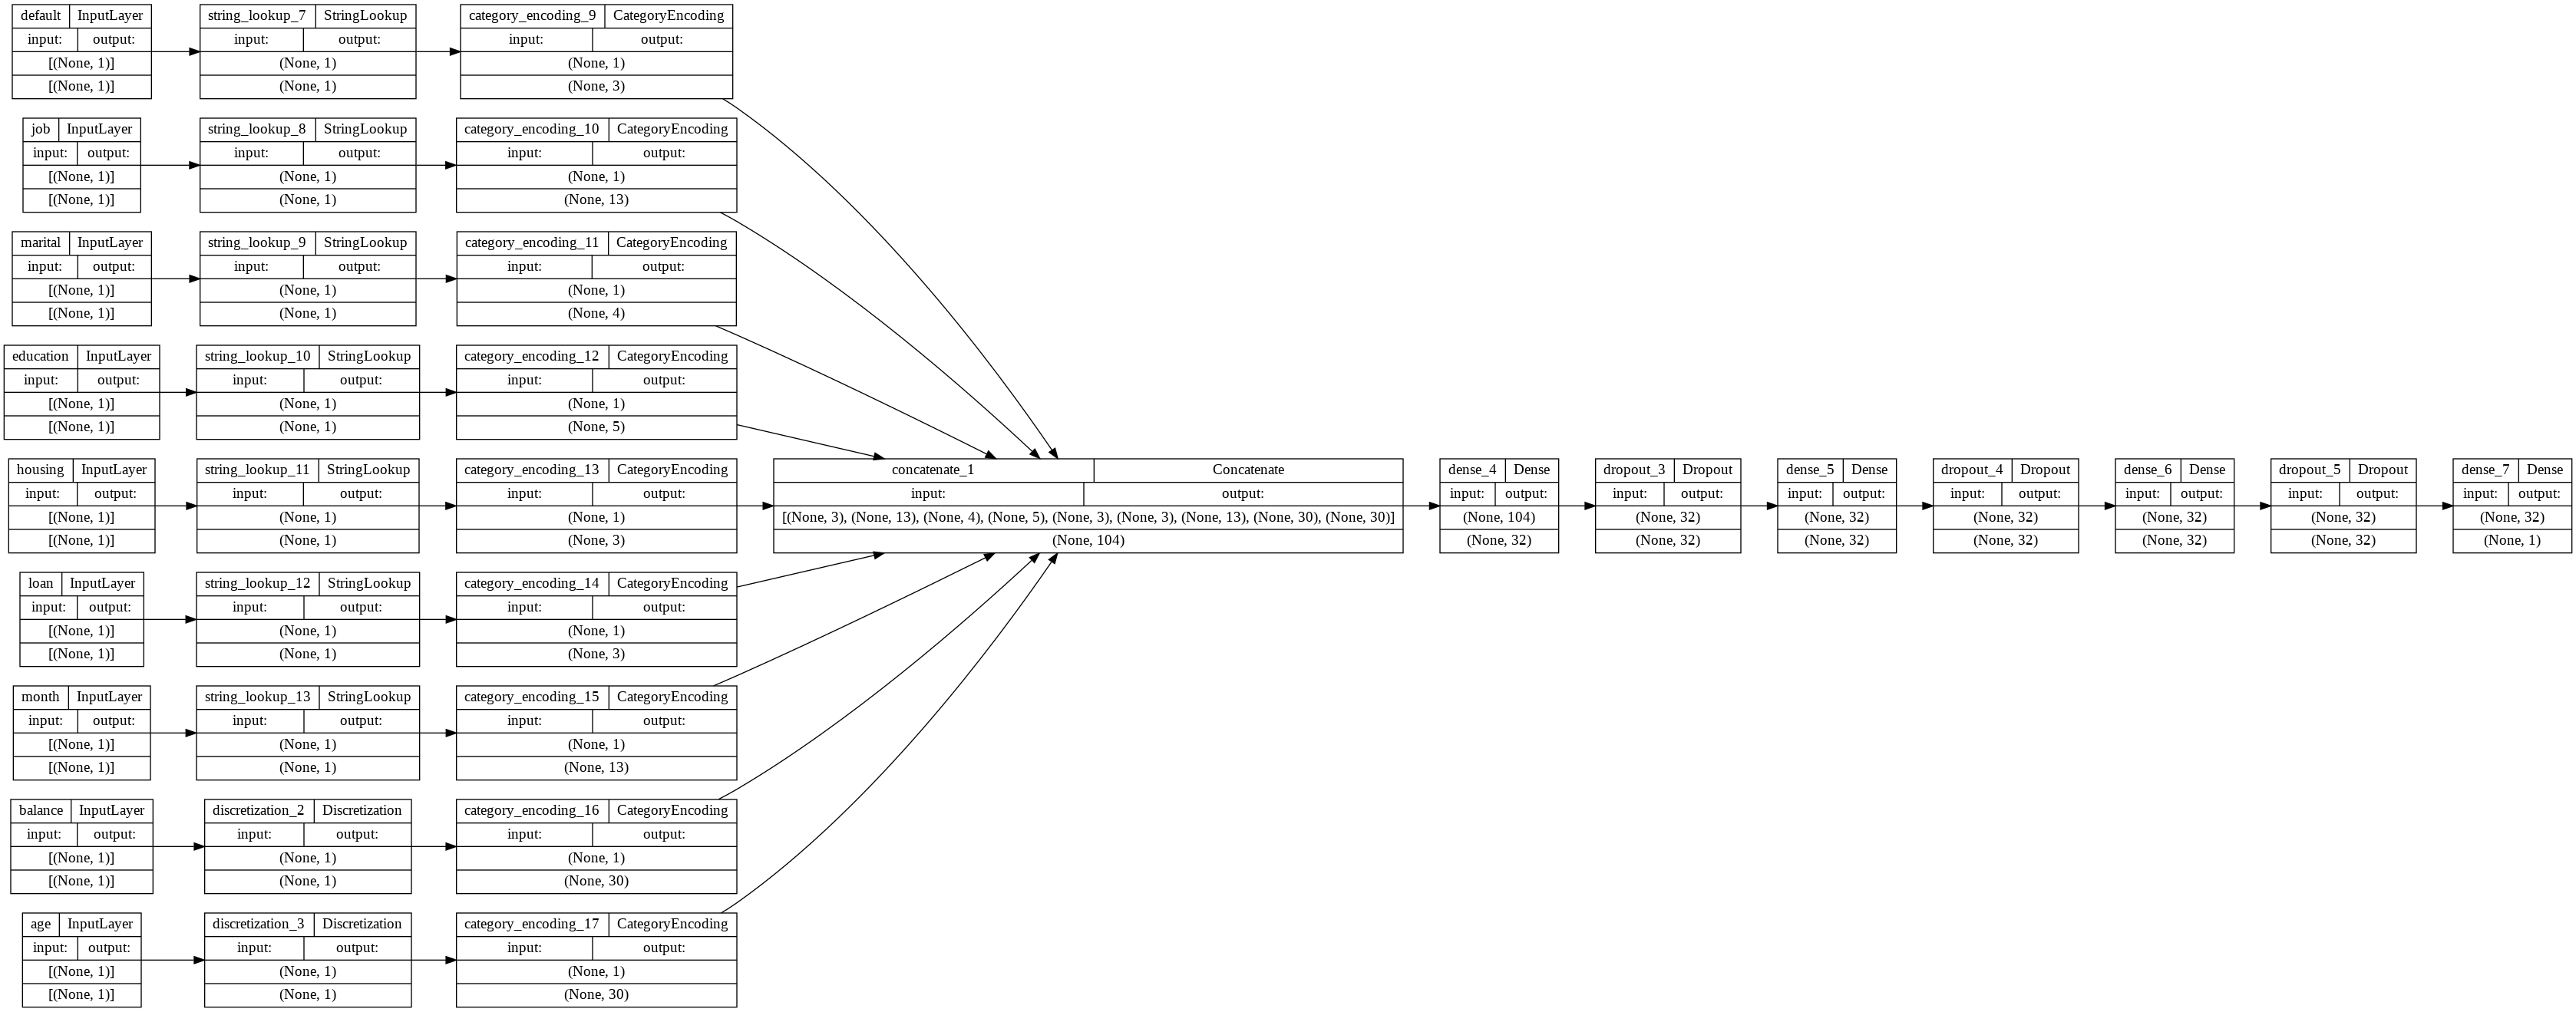

In [75]:
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [76]:
METRICS = [
      tf.keras.metrics.TruePositives(name='tp'),
      tf.keras.metrics.FalsePositives(name='fp'),
      tf.keras.metrics.TrueNegatives(name='tn'),
      tf.keras.metrics.FalseNegatives(name='fn'), 
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),
]
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=METRICS)

In [77]:
es_loss = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=30, restore_best_weights=True)
history = model.fit(train_ds, epochs=100, validation_data=val_ds, validation_steps=32, callbacks=[es_loss], steps_per_epoch=32)

Epoch 1/100
32/32 [==============================] - 5s 100ms/step - loss: 0.7076 - tp: 1088.0000 - fp: 1156.0000 - tn: 917.0000 - fn: 935.0000 - accuracy: 0.4895 - precision: 0.4848 - recall: 0.5378 - val_loss: 0.6843 - val_tp: 749.0000 - val_fp: 189.0000 - val_tn: 1851.0000 - val_fn: 1307.0000 - val_accuracy: 0.6348 - val_precision: 0.7985 - val_recall: 0.3643
Epoch 2/100
32/32 [==============================] - 3s 87ms/step - loss: 0.6959 - tp: 1151.0000 - fp: 1055.0000 - tn: 988.0000 - fn: 902.0000 - accuracy: 0.5222 - precision: 0.5218 - recall: 0.5606 - val_loss: 0.6803 - val_tp: 1084.0000 - val_fp: 222.0000 - val_tn: 1780.0000 - val_fn: 1010.0000 - val_accuracy: 0.6992 - val_precision: 0.8300 - val_recall: 0.5177
Epoch 3/100
32/32 [==============================] - 2s 74ms/step - loss: 0.6912 - tp: 1136.0000 - fp: 1041.0000 - tn: 1016.0000 - fn: 903.0000 - accuracy: 0.5254 - precision: 0.5218 - recall: 0.5571 - val_loss: 0.6758 - val_tp: 1164.0000 - val_fp: 215.0000 - val_tn: 18

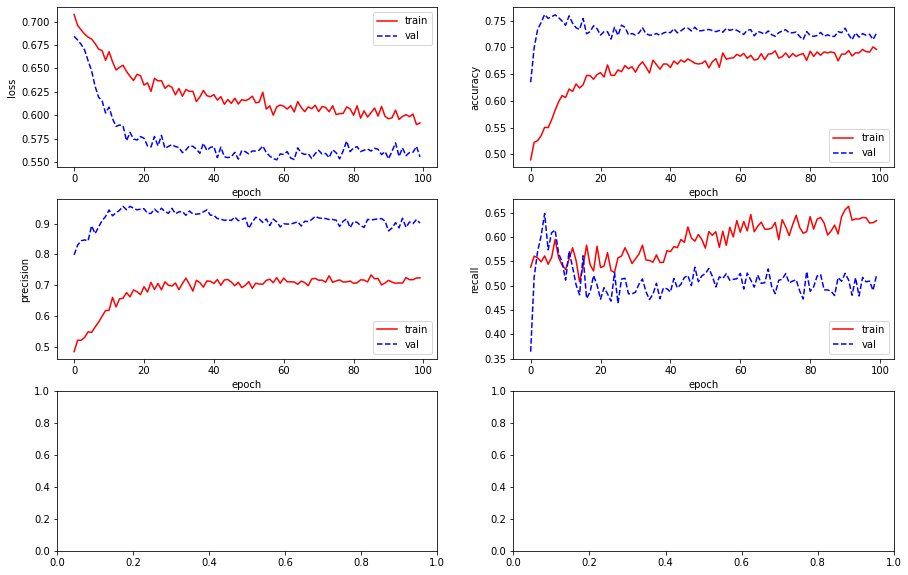

In [79]:
metric = ['loss', 'accuracy', 'precision', 'recall']
plot_metric(3,2, history, metric)

In [80]:
predict_test = model.predict(test_ds)
test_ds_unbach = test_ds.unbatch()
label_test = [i[1] for i in list(test_ds_unbach.as_numpy_iterator())]


36/36 [==============================] - 0s 8ms/step - loss: 0.5731 - tp: 307.0000 - fp: 876.0000 - tn: 3124.0000 - fn: 214.0000 - accuracy: 0.7589 - precision: 0.2595 - recall: 0.5893
loss :  0.5730841159820557
tp :  307.0
fp :  876.0
tn :  3124.0
fn :  214.0
accuracy :  0.758902907371521
precision :  0.25950971245765686
recall :  0.5892514586448669
Legitimate Transactions Detected (True Negatives):  3124
Legitimate Transactions Incorrectly Detected (False Positives):  876
Fraudulent Transactions Missed (False Negatives):  214
Fraudulent Transactions Detected (True Positives):  307
Total Fraudulent Transactions:  521


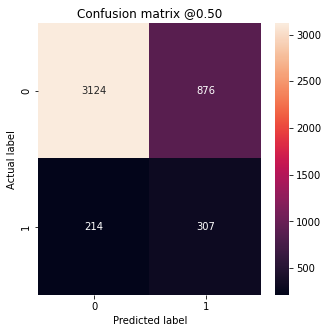

In [81]:
model_evaluate = model.evaluate(test_ds)
for name_metric, value_evaluate in zip(model.metrics_names, model_evaluate):
  print(name_metric, ': ', value_evaluate)

plot_confution_matrix(label_test, predict_test)

In [82]:
dataset_test.sort_values(by=["target"], ascending=False).head()

,age,job,marital,education,default,balance,housing,loan,month,target
3930,51,retired,divorced,secondary,no,1679,no,no,aug,1
702,32,management,divorced,tertiary,no,874,no,no,aug,1
1876,26,blue-collar,single,primary,no,-887,yes,no,may,1
2865,51,housemaid,divorced,secondary,no,9228,no,no,jul,1
1872,34,admin.,married,secondary,no,247,no,no,oct,1


In [83]:
sample = {
    'age': 51,
    'job': 'retired',
    'marital': 'divorced',
    'education': 'secondary',
    'balance': 1679,
    'housing': 'no',
    'loan': 'no',
    'month': 'aug',
    'default': 'no'
}

input_dict = {name: tf.convert_to_tensor([value]) for name, value in sample.items()}
predictions = model.predict(input_dict)

print(
    f"Probabilitas untuk berlangganan deposito berjangka adalah {round(100 * predictions[0][0], 2)} % "
    f"untuk setuju "
    f"{predictions}"
)

Probabilitas untuk berlangganan deposito berjangka adalah 57.16 % untuk setuju [[0.5715836]]
